# BrainPy

In this chapter, we will briefly introduce how to realize computational neuroscience model with BrainPy. For more detailed documents and tutorials, please check our github repository [BrainPy](https://github.com/PKU-NIP-Lab/BrainPy) and [BrainModels](https://github.com/PKU-NIP-Lab/BrainModels).

`BrainPy` is a Python platform for computational neuroscience and brain-inspired computation. To model with BrainPy, users should follow 3 steps:

1) Define Python classes for neuron and synapse models. BrainPy provide base classes for different kinds of models, users only need to inherit from those base classes, and define specific methods to tell BrainPy what operations they want the models to take during the simulation. In this process, BrainPy will assist users in numerical integration of differential equations (ODE, SDE, etc.), adaptation of various backend (`Numpy`, `PyTorch`, etc.) and other functions to simplify code logic.

2) Instantiate Python classes as objects of neuron group and synapse connection groups, pass the instantiated objects to BrainPy class `Network`, and call method `run` to simulate the network.

3) Call BrainPy modules like `measure` module and `visualize` module to display the simulation results.

With this overall concept of BrainPy, we will go into more detail about implementations in the following sections. In neural systems, neurons are connected by synapses to build networks, so we will introduce neuron models, synapse models and network models in order.

## 1. Neuron models

Neuron models can be classified into three types from complex to simple: biophysical models, reduced models and firing rate models.

### 1.1 Biophysical models

#### 1.1.1 Hodgkin-Huxley model

In 1952, Hodgkin and Huxley recorded the generation of action potential on squid giant axons with voltage clamp technique, and proposed the canonical neuron model called Hodgkin-Huxley model (HH model). 

<img src="../images/brainpy_tutorials/1-1.png">	
<center><b> Fig. 1-1 Neuron membrane | NeuroDynamics </b></center>

Fig. 1-1 is a general diagram of neuron membrane with phospholipid bilayer and ion channels. The Na+ ion concentration is higher out of the neuron, and K+ ion concentration is higher in the neuron. Intracellular potential is  lower than extracellular potential.

<img src="../images/brainpy_tutorials/1-2.png">	
<center><b>Fig. 1-2 Equivalent circuit diagram | NeuroDynamics </b></center>

The equivalent circuit diagram of Fig.1-1 is shown in Fig. 1-2, in which the battery $E_L$ refers to the potential difference across membrane, electric current $I$ refers to the external stimulus, capacitance $C$ refers to the hydrophobic phospholipid bilayer with low conductance, resistance $R$ refers to the resistance correspond to leaky current, i.e. the resistance of all non-specific ion channels. 

As Na+ ion channel and K+ ion channel are important in the generation of action potentials, these two ion channels are modeled as the two resistances $R_{Na}$ and $R_K$ in parallel on the right side of the circuit diagram, and the two batteries $E_{Na}$ and $E_K$ refer to the ion potential differences caused by ion concentration differences of Na+ and K+, respectively.

Consider the Kirchhoff’s first law, that is,  for any node in an electrical circuit, the sum of currents flowing into that node is equal to the sum of currents flowing out of that node, Fig. 1-2 can be modeled as differential equations:

$$ C \frac{dV}{dt} = -(\bar{g}_{Na} m^3 h (V - E_{Na}) + \bar{g}_K n^4(V - E_K) + g_{leak}(V - E_{leak})) + I(t) $$

$$\frac{dx}{dt} = \alpha_x(1-x) - \beta_x , x \in \{ Na, K, leak \} $$

That is the HH model. Note that in equation 1, HH model introduces three gating variables m, n and h to control the open/close state of ion channels. To be accurate, variables m and h control the state of Na+ ion channel, and variable n control the state of K+ ion channel. Gating variable dynamics can be expressed in Markov-like form, in which $\alpha_x$ refers to the activation rate of gating variable x, and $\beta_x$ refers to the de-activation rate of x. The expressions of $\alpha_x$ and $\beta_x$ (as shown in equations below) are fitted by experimental data.

$$ \alpha_m(V) = \frac{0.1(V+40)}{1 - exp(\frac{-(V+40)}{10})}$$

$$ \beta_m(V) = 4.0 exp(\frac{-(V+65)}{18})$$

$$ \alpha_h(V) = 0.07 exp(\frac{-(V+65)}{20})$$

$$ \beta_h(V) = \frac{1}{1 + exp(\frac{-(V + 35)}{10})}$$

$$ \alpha_n(V) = \frac{0.01(V+55)}{1 - exp(\frac{-(V+55)}{10})}$$

$$ \beta_n(V) = 0.125 exp(\frac{-(V+65)}{80})$$

How can the users transform these differential equations to code with BrainPy? Take HH model as an example, we may look closely at this process.

**************************

*Note: Readers should pay special attention to discriminate between the terms “model parameters”, “model variables” in dynamic systems and the terms “parameters”, “variables” in programming.*

In BrainPy, users define neuron and synapse models as Python classes. All the classes users may use, as shown in Fig. 1-3, derive from one base class `DynamicSystem`. A neuron model should inherit from the subclass `NeuGroup` of `DynamicSystem` class, and synapse model should inherit from the subclass `TwoEndConn` or `ThreeEndConn`, rely on the number of neurons connected by a single synapse.

<img src="../images/brainpy_tutorials/1-3.png"> 
<center><b> Fig. 1-3 Class inheritance of BrainPy </b></center>

As for HH neuron model, the `HH` class should inherit from `NeuGroup` class. Objects of `HH` class represent groups of HH neuron, and every single neuron in the group will be computed separately. 

    class HH(bp.NeuGroup):
        target_backend = 'general'

Firstly, in HH class definition, users may set variable `target_backend` to specify backend. The value can be set as `general`, which means any backend is supported; it can also be set as a list of backend names:

        target_backend = ['numpy', 'numba', 'pytorch']

The code implementation of model rely on the backend. For example, the acceleration mechanism of `PyTorch` differs from `Numba`, so we may realize the same model differently to maximize the accelerate effect.

Next, we define the differential equation in `derivative` method. Users pass the model variables, time stamp `t` and other model parameters to `derivative` method, BrianPy will classify this three types by the incoming parameter order and integrate the model variables only.

        @staticmethod
        def derivative(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
            alpha_m = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
            beta_m = 4.0 * bp.ops.exp(-(V + 65) / 18)
            dmdt = alpha_m * (1 - m) - beta_m * m
            
            dhdt = ...
            
            dndt = ...

            I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
            I_K = (gK * n ** 4.0) * (V - EK)
            I_leak = gL * (V - EL)
            dVdt = (- I_Na - I_K - I_leak + Iext) / C

            return dVdt, dmdt, dhdt, dndt

In the method, we compute the right hand of HH equations (1) – (8), and return $dV/dt$, $dm/dt$, $dn/dt$, $dh/dt$ in order.

However, if you are familiar with numerical integration, you may find that we have not transform the derivatives $dx/dt$ into update processes from $x(t)$ to $x(t+1)$. Don't worry, BrainPy will automatically complete this step of transformation, the details will soon be explained in the constructor.

The contructor of HH class `__init__` needs three types of incoming parameters:

1)	Parameter 	`size`: the number of neurons contained by a class object. Ex. If `size=100`, this object of HH neuron group will include 100 HH neurons.

2)	Parameter list `E_Na` ~ `V_th`: a list of model parameters relies on the model. The number and value of model parameters in this list vary according to the model.

3)	Key word arguments list `**kwargs`: Variable dictionary of key word arguments. `**kwargs` are passed to superclass `NeuGroup` at the end of constructor, and are handled by the super class.

        def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
                 EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
            # parameters
            self.ENa = ENa
            ...
            self.V_th = V_th
    
            # variables
            self.V = -65. * bp.ops.ones(size)
            self.m = 0.5 * bp.ops.ones(size)
            self.h = 0.6 * bp.ops.ones(size)
            self.n = 0.32 * bp.ops.ones(size)
            self.spike = bp.ops.zeros(size, dtype=bool)
            self.input = bp.ops.zeros(size)

            # numerical solver
            self.integral = bp.odeint(f=self.derivative)
            super(HH, self).__init__(size=size, **kwargs)

The difference between model parameters (`ENa`, `gNa`, etc.) and model variables (`V`, `m`, `n`, etc.) is, model parameters are only sensitive to the model, but model variables also consider the number of neurons in this neuron group. As shown in Fig. 1-5, if 100 HH neurons are included in one object, then each model parameter is a floating point number, while each model variable is saved in memory as a floating point vector with length 100.

<img src="../images/brainpy_tutorials/1-5.png"> 
<center><b>Fig.1-5 model memory</b></center>

Then we define the numerical method `integral`. Call `odeint` function provided by BrainPy to specify the numerical method are to be used, and `odeint` function will recompile `derivative` method, transform the derivatives to variable update processes. 

BrainPy supports several numerical integration methods including Euler method, Ronge-Kutta method, etc. Users may choose a method with parameter `method`.

        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
    
At the end of constructor, pass parameter `size` and `**kwargs` to super class `NeuGroup`, finish the initialization of HH class.

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                          self.C, self.gNa, self.ENa, self.gK,
                          self.EK, self.gL, self.EL, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

Define `update` method of HH class. Simulation is a series of computing operations on discrete time series, so in `update` method we tell BrainPy what to do on each time step. As for HH model, we call `integral` method to update variables `V`, `m`, `n`, `h`, judge if there are spikes on each neuron and reset the external input of current moment.

To use a well-defined HH class, we instantiate a neuron group with 100 HH neurons. The parameter `monitors` is passed into super class `NeuGroup` as `**kwargs`. All the model variables marked by the monitor list will be recorded by BrainPy during the simulation, and users can access the records later as `neu.mon.*`.

    neu = HH(size = 100, monitors=['V'])
    net = bp.Network(neu)
    net.run(duration = 200., inputs=(neu, 'input', 10.))

    bp.visualize.line_plot(neu.mon.ts, neu.mon.V, show=True)

Pass neuron group object `neu` to class `Network`, instantiate a network object `net` including this neuron group. Call method `run` of class `Network`, simulate for 200 ms and give all the neurons  external inputs of amplitude 10 during the simulation. After, users may call the `visualize` module of BrainPy to display the results.

In [2]:
import brainpy as bp

class HH(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
        I_K = (gK * n ** 4.0) * (V - EK)
        I_leak = gL * (V - EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / C

        return dVdt, dmdt, dhdt, dndt

    def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
                 EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th

        # variables
        num = bp.size2len(size)
        self.V = -65. * bp.ops.ones(num)
        self.m = 0.5 * bp.ops.ones(num)
        self.h = 0.6 * bp.ops.ones(num)
        self.n = 0.32 * bp.ops.ones(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        self.input = bp.ops.zeros(num)

        # numerical solver
        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
        super(HH, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                                   self.C, self.gNa, self.ENa, self.gK,
                                   self.EK, self.gL, self.EL, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

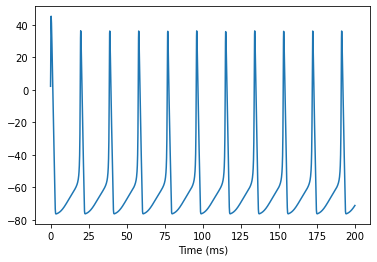

In [3]:
import brainpy as bp

neu = HH(100, monitors=['V'])
net = bp.Network(neu)
net.run(200., inputs=(neu, 'input', 5.))

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, show=True)

The V-t plot of HH model simulated with BrainPy is painted above. During an action potential of HH model, there is four periods: integrate, spike, reset and refractory period.

These periods are similar to the typical behavior of neurons found in biophysical experiments, and can be mapped to the equations. For example, the existence of refractory period is because of the different activation and de-activation rate of gating variables.

### 1.2 Reduced models

Inspired by biophysical experiments, Hodgkin-Huxley model is precise but costful. Researchers proposed the reduced models to reduce the consumption on computing resources and running time in simulation. 

These models are simple and easy to compute, while they can still reproduce the main pattern of neuron behavior. Although their representation capabilities are not as good as biophysical models, such a loss of accuracy is acceptable comparing to their simplicity.

#### 1.2.1 Leaky Integrate-and-Fire model

The most typical reduced model is the Leaky Integrate-and-Fire model (LIF model) presented by Lapicque (1907).  LIF model can be seen as a combination of integrate process represented by differential equation and spike process represented by conditional judgment:

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + R I(t)$$

If  $V > V_{th}$, neuron fire, 

$$ V \gets V_{reset}$$.

The `derivative` method of LIF model is simpler than of HH model. However the `update` method is more complex because of the conditional judgement.

In [7]:
class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, Iext, V_rest, R, tau):
        dvdt = (-V + V_rest + R * Iext) / tau
        return dvdt

    def __init__(self, size, t_refractory=5., V_rest=0.,
                 V_reset=-5., V_th=20., R=1., tau=10., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        num = bp.size2len(size)
        self.t_last_spike = bp.ops.ones(num) * -1e7
        self.input = bp.ops.zeros(num)
        self.V = bp.ops.ones(num) * V_rest
        self.refractory = bp.ops.zeros(num, dtype=bool)
        self.spike = bp.ops.zeros(num, dtype=bool)

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        # if neuron is in refractory period
        V = self.integral(self.V, _t, self.input, self.V_rest, self.R, self.tau)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V  # if neuron spikes
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

Note that we write `update` method in vector form here. If the backend is `Numba`, we can also realize LIF model with `prange` loop, for `Numba` provides excellent parallel acceleration on `prange` loop:

    def update(self, _t):
        for i in prange(self.size[0]):
            spike = 0.
            refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
            if not refractory:
                V = self.integral(self.V[i], _t, self.input[i], self.V_rest, self.R, self.tau)
                spike = (V >= self.V_th)
                if spike:
                    V = self.V_reset
                    self.t_last_spike[i] = _t
                self.V[i] = V
            self.spike[i] = spike
            self.refractory[i] = refractory or spike
            self.input[i] = 0.

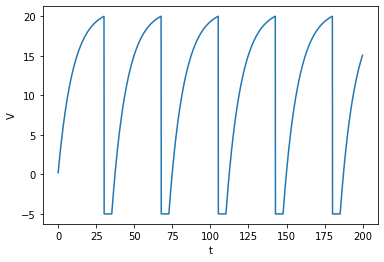

In [8]:
neu = LIF(100, monitors=['V', 'refractory', 'spike'])
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.))
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

Compare to the HH model, LIF model does not model the spike period of action potentials, in which the membrane potential bursts.

#### 1.2.2 Quadratic Integrate-and-Fire model

To persue higher representation capability, Latham et al. (2000) proposed Quadratic Integrate-and-Fire model, in which they add a second order term in differential equation so the neurons can generate spike better.

$$\tau\frac{d V}{d t}=a_0(V-V_{rest})(V-V_c) + RI(t)$$

In [10]:
class QuaIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, V_c, R, tau, a_0):
        dVdt = (a_0 * (V - V_rest) * (V - V_c) + R * I_ext) / tau
        return dVdt

    def __init__(self, size, V_rest=-65., V_reset=-68.,
                 V_th=-30., V_c=-50.0, a_0=.07,
                 R=1., tau=10., t_refractory=0., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_c = V_c
        self.a_0 = a_0
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        num = bp.size2len(size)
        self.V = bp.ops.ones(num) * V_reset
        self.input = bp.ops.zeros(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        self.refractory = bp.ops.zeros(num, dtype=bool)
        self.t_last_spike = bp.ops.ones(num) * -1e7

        self.integral = bp.odeint(f=self.derivative, method='euler')

        super(QuaIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V = self.integral(self.V, _t, self.input, self.V_rest,
                          self.V_c, self.R, self.tau, self.a_0)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

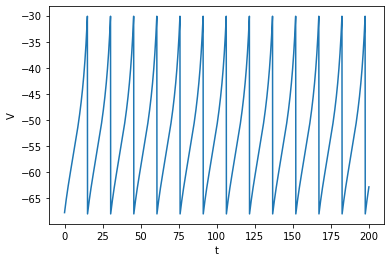

In [12]:
neu = QuaIF(100, monitors=['V', 'refractory', 'spike'])
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.))
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

#### 1.2.3 Exponential Integrate-and-Fire model
Exponential Integrate-and-Fire model (ExpIF model) (Fourcaud-Trocme et al., 2003) is more expressive than QuaIF model.

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} + R I(t)$$

In [19]:
class ExpIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, delta_T, V_T, R, tau):
        dvdt = (- V + V_rest \
                + delta_T * bp.ops.exp((V - V_T) / delta_T) + R * I_ext) \
               / tau
        return dvdt

    def __init__(self, size, V_rest=-65., V_reset=-68.,
                 V_th=-30., V_T=-59.9, delta_T=3.48,
                 R=10., C=1., tau=10., t_refractory=1.7,
                 **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_T = V_T
        self.delta_T = delta_T
        self.R = R
        self.C = C
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.refractory = bp.ops.zeros(size, dtype=bool)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(ExpIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V = self.integral(self.V, _t, self.input, self.V_rest, self.delta_T, self.V_T, self.R, self.tau)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

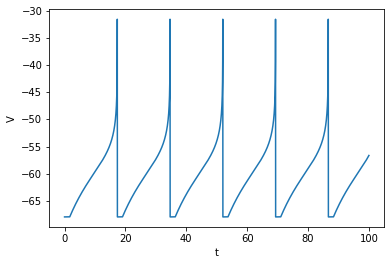

In [20]:
neu = ExpIF(16, monitors=['V', 'spike', 'refractory'])

neu.run(duration=100, inputs=('input', 1.))
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V",
                       show=True)

With the model parameter $V_T$, ExpIF model reproduce the burst of membrane potential before action potentials.

#### 1.2.4 Adaptative Exponential Integrate-and-Fire model

To reproduce the adaptation behavior of neurons, researchers add a weight variable w to existing integrate-and-fire models like LIF, QuaIF and ExpIF models. Here we introduce a typical one: Adaptative Exponential Integrate-and-Fire model (AdExIF model)(Gerstner et al, 2014).

$$ \tau_m \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} - R w + R I(t)$$
$$ \tau_w \frac{dw}{dt} = a(V - V_{rest})- w + b \tau_w \sum \delta(t - t^f))$$

Facing a constant input, the firing rate of AdExIF neuron decreases over time. These adaptation is controlled by the weight variable w.

In [25]:
class AdExIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, w, t, I_ext, V_rest, delta_T, V_T, R, tau, tau_w, a):
        dwdt = (a * (V - V_rest) - w) / tau_w
        dVdt = (- (V - V_rest) + delta_T * bp.ops.exp((V - V_T) / delta_T) - R * w + R * I_ext) / tau
        return dVdt, dwdt

    def __init__(self, size, V_rest=-65., V_reset=-68.,
                 V_th=-30., V_T=-59.9, delta_T=3.48,
                 a=1., b=1., R=10., tau=10., tau_w=30.,
                 t_refractory=0., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_T = V_T
        self.delta_T = delta_T
        self.a = a
        self.b = b
        self.R = R
        self.tau = tau
        self.tau_w = tau_w
        self.t_refractory = t_refractory

        # variables
        num = bp.size2len(size)
        self.V = bp.ops.ones(num) * V_reset
        self.w = bp.ops.zeros(size)
        self.input = bp.ops.zeros(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        self.refractory = bp.ops.zeros(num, dtype=bool)
        self.t_last_spike = bp.ops.ones(num) * -1e7

        self.integral = bp.odeint(f=self.derivative, method='euler')

        super(AdExIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V, w = self.integral(self.V, self.w, _t, self.input, self.V_rest,
                             self.delta_T, self.V_T, self.R, self.tau,
                             self.tau_w, self.a)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.w = bp.ops.where(spike, w + self.b, w)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

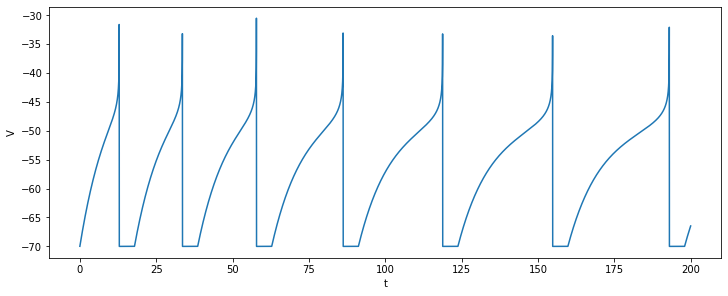

In [30]:
import brainpy as bp

backend = 'numpy'
bp.backend.set(backend=backend, dt=.005)

duration = 200
I_ext = 65
neu = AdExIF(size=1, monitors=['V', 'spike', 'refractory'],
             a=.5, b=7, R=.5, tau=9.9, tau_w=100,
             V_reset=-70, V_rest=-70, V_th=-30,
             V_T=-50, delta_T=2., t_refractory=5.)

neu.run(duration, inputs=('input', I_ext))
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V")


#### 1.2.5 Resonate-and-Fire model

Other than the integrators we introduced above, there is another neuron type called resonator. From Fig.1-12 we may see, resonators' membrane potentials oscillate under the threshold potential when there is no spike, that's the reason resonators prefer rhythm inputs than high frequency inputs.

<img src="../images/brainpy_tutorials/1-12.png"> 
<center><b>Fig.1-12 Integrator vs. Resonator</b></center>

This subthreshold oscillations of resonators are caused by the interactions between ion channels. To model the oscillations, Izhikevich and Eugene (2001) proposed Resonate-and-Fire model (RF model) which includes two model variables x, y to represent the current-like and voltage-like variables in neurons.

$$\frac{dx}{dt} = bx - wy$$

$$\frac{dy}{dt} = wx + by$$

When spike,

$$ x \gets 0, y \gets 1$$

In [13]:
class ResonateandFire(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(y, x, t, b, omega):
        dydt = omega * x + b * y
        dxdt = b * x - omega * y
        return dydt, dxdt

    def __init__(self, size, b=-1., omega=10.,
                 V_th=1., V_reset=1., x_reset=0.,
                 **kwargs):
        # parameters
        self.b = b
        self.omega = omega
        self.V_th = V_th
        self.V_reset = V_reset
        self.x_reset = x_reset

        # variables
        self.y = bp.ops.zeros(size)
        self.x = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)

        self.integral = bp.odeint(self.derivative)
        super(ResonateandFire, self).__init__(size=size, **kwargs)

    def update(self, _t):
        x = self.x + self.input
        y, x = self.integral(self.y, x, _t, self.b, self.omega)
        sp = (y > self.V_th)
        y[sp] = self.V_reset
        x[sp] = self.x_reset
        self.y = y
        self.x = x
        self.spike = sp
        self.input[:] = 0

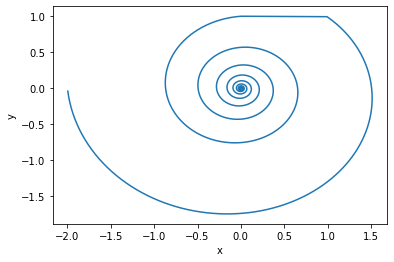

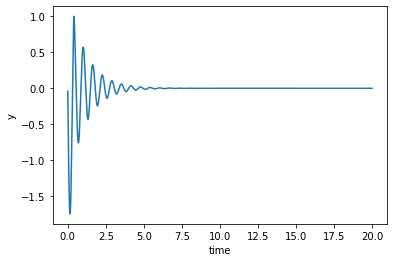

In [14]:
bp.backend.set('numpy', dt=0.002)
group = ResonateandFire(1, monitors=['x', 'y'], show_code=False)
current = bp.inputs.spike_current(points=[0.0], lengths=0.002,
                                  sizes=-2., duration=20.)
group.run(duration=20., inputs=('input', current))
bp.visualize.line_plot(
    group.mon.x, group.mon.y, 
    xlabel = 'x', ylabel = 'y',
    show=True)
bp.visualize.line_plot(
    group.mon.ts, group.mon.y, 
    xlabel = 'time', ylabel = 'y',
    show=True)

After a short stimulus is given, paint the trajectory of x and y on complex field, we can see the both variables decaying to zero in a nearly circle trajectory. The voltage-like variable y acts like a resonator here.

#### 1.2.6 Hindmarsh-Rose model

To simulate the bursting spike pattern in neurons (i.e. continuously firing in a short time period), Hindmarsh and Rose (1984) proposed Hindmarsh-Rose neuron model, import a third model variable as slow variable to control the bursting of neuron.

$$\frac{d V}{d t} = y - a V^3 + b V^2 - z + I$$

$$\frac{d y}{d t} = c - d V^2 - y$$

$$\frac{d z}{d t} = r (s (V - V_{rest}) - z)$$

In [17]:
class HindmarshRose(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, y, z, t, a, b, I_ext, c, d, r, s, V_rest):
        dVdt = y - a * V * V * V + b * V * V - z + I_ext
        dydt = c - d * V * V - y
        dzdt = r * (s * (V - V_rest) - z)
        return dVdt, dydt, dzdt

    def __init__(self, size, a=1., b=3.,
                 c=1., d=5., r=0.01, s=4.,
                 V_rest=-1.6, **kwargs):
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.r = r
        self.s = s
        self.V_rest = V_rest

        # variables
        self.z = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.V = bp.ops.ones(size) * -1.6
        self.y = bp.ops.ones(size) * -10.

        self.integral = bp.odeint(self.derivative)
        super(HindmarshRose, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.V, self.y, self.z = self.integral(self.V, self.y, self.z, _t,
                                               self.a, self.b, self.input,
                                               self.c, self.d, self.r, self.s,
                                               self.V_rest)
        self.input[:] = 0.

parameters is set to firing mode <irregular_bursting>


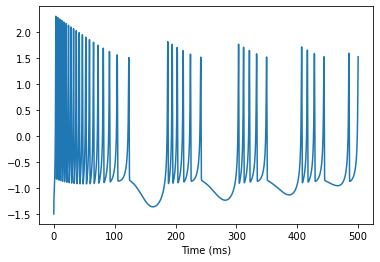

In [18]:
import brainpy as bp

bp.backend.set('numba', dt=0.02)
mode = 'irregular_bursting'
param = {'quiescence': [1.0, 2.0],  # a
         'spiking': [3.5, 5.0],  # c
         'bursting': [2.5, 3.0],  # d
         'irregular_spiking': [2.95, 3.3],  # h
         'irregular_bursting': [2.8, 3.7],  # g
         }
# set params of b and I_ext corresponding to different firing mode
print(f"parameters is set to firing mode <{mode}>")

group = HindmarshRose(size=10, b=param[mode][0],
                                          monitors=['V', 'y', 'z'])

group.run(500., inputs=('input', param[mode][1]))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

In the variable-t plot below, the three model variables x, y, z change on time. Variable z changes much slower than x and y, so it is the slow variable.

We should mention that x and y are changing periodically during the simulation. Can BrainPy help us analysis the reason of this periodicity?

parameters is set to firing mode <spiking>


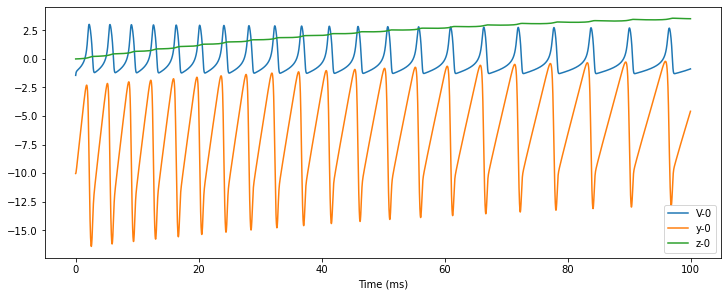

In [19]:
mode = 'spiking'
print(f"parameters is set to firing mode <{mode}>")
group = HindmarshRose(size=10, b=param[mode][0],
                      monitors=['V', 'y', 'z'])
group.run(100., inputs=('input', param[mode][1]))
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend = 'V')
bp.visualize.line_plot(group.mon.ts, group.mon.y, legend = 'y')
bp.visualize.line_plot(group.mon.ts, group.mon.z, legend = 'z', show=True)

Yes. With the module `analysis` of BrainPy, users can do simple dynamic analysis, including 1D/2D bifurcation analysis, fast-slow variable bifurcation analysis and 2D/3D phase plane drawing.

Here we take 2D phase plane drawing as an example. Passing the differential eqution, target variables, fixed variables and parameters to `PhasePlane` class in `analysis` module, we can instantiate a PhasePlane analyzer object based on differential equation.

In [20]:
# Phase plane analysis
ppanalyzer = bp.analysis.PhasePlane(
    neu.integral,
    target_vars = {'V': [-3., 3.], 'y': [-20., 5.]},
    fixed_vars = {'z': 0.},
    pars_update = {'I_ext':param[mode][1], 'a': 1., 'b': 3., 
                   'c': 1., 'd': 5., 'r': 0.01, 's': 4.,
                   'V_rest': -1.6}
)
ppanalyzer.plot_nullcline()
ppanalyzer.plot_fixed_point()
ppanalyzer.plot_vector_field()
ppanalyzer.plot_trajectory(
    [{'V': 1., 'y': 0., 'z': -0.}],
    duration=100., 
    show=True
)

ModelUseError: "a" is not a valid parameter in "<function ode_brainpy_int_of_derivative at 0x7f8d69676550>" model.

<img src="../images/brainpy_tutorials/1-16.png">

Call the `plot_nullcline`, `plot_vector_field`, `plot_fixed_point`, `plot_trajectory` method of phase plane analyzer, users can paint nullcline, vector filed, fixed points and trajectory of the dynamic system.

In HR model, the trajectory of x and y approaches a limit cycle, that’s why these two variables change periodically.

#### 1.2.7 Generalized Integrate-and-Fire model

Generalized Integrate-and-Fire model (GIF model)(Mihalaş et al., 2009) integrates several firing patterns in one model. With 4 model variables, it can generate more than 20 types of firing patterns, and is able to alternate between patterns by fitting parameters.

$$\frac{d I_j}{d t} = - k_j I_j, j = {1, 2}$$

$$\tau \frac{d V}{d t} = ( - (V - V_{rest}) + R\sum_{j}I_j + RI)$$

$$\frac{d V_{th}}{d t} = a(V - V_{rest}) - b(V_{th} - V_{th\infty})$$

When V meet Vth, Generalized IF neuron fire:

$$I_j \leftarrow R_j I_j + A_j$$

$$V \leftarrow V_{reset}$$

$$V_{th} \leftarrow max(V_{th_{reset}}, V_{th})$$

In [21]:
class GeneralizedIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(I1, I2, V_th, V, t,
                   k1, k2, a, V_rest, b, V_th_inf,
                   R, I_ext, tau):
        dI1dt = - k1 * I1
        dI2dt = - k2 * I2
        dVthdt = a * (V - V_rest) - b * (V_th - V_th_inf)
        dVdt = (- (V - V_rest) + R * I_ext + R * I1 + R * I2) / tau
        return dI1dt, dI2dt, dVthdt, dVdt

    def __init__(self, size, V_rest=-70., V_reset=-70.,
                 V_th_inf=-50., V_th_reset=-60., R=20., tau=20.,
                 a=0., b=0.01, k1=0.2, k2=0.02,
                 R1=0., R2=1., A1=0., A2=0.,
                 **kwargs):
        # params
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th_inf = V_th_inf
        self.V_th_reset = V_th_reset
        self.R = R
        self.tau = tau
        self.a = a
        self.b = b
        self.k1 = k1
        self.k2 = k2
        self.R1 = R1
        self.R2 = R2
        self.A1 = A1
        self.A2 = A2

        # vars
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.I1 = bp.ops.zeros(size)
        self.I2 = bp.ops.zeros(size)
        self.V = bp.ops.ones(size) * -70.
        self.V_th = bp.ops.ones(size) * -50.

        self.integral = bp.odeint(self.derivative)
        super(GeneralizedIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        I1, I2, V_th, V = self.integral(
            self.I1, self.I2, self.V_th, self.V, _t,
            self.k1, self.k2, self.a, self.V_rest,
            self.b, self.V_th_inf,
            self.R, self.input, self.tau)
        sp = (self.V_th < V)
        V[sp] = self.V_reset
        I1[sp] = self.R1 * I1[sp] + self.A1
        I2[sp] = self.R2 * I2[sp] + self.A2
        reset_th = np.logical_and(V_th < self.V_th_reset, sp)
        V_th[reset_th] = self.V_th_reset
        self.spike = sp
        self.I1 = I1
        self.I2 = I2
        self.V_th = V_th
        self.V = V
        self.input[:] = 0.

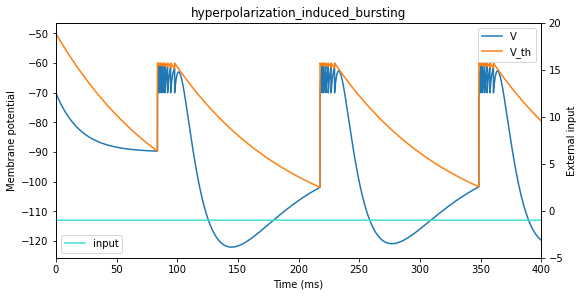

In [29]:
import matplotlib.pyplot as plt
import numpy as np

size=10
mode = "hyperpolarization_induced_bursting"
neu = GeneralizedIF(size, monitors=['V', 'V_th', 'I1', 'I2', 'input'])
neu.V_th_reset = -60.
neu.V_th_inf = -120.
neu.A1 = 10.
neu.A2 = -0.6
neu.V_th = bp.ops.ones(size) * -50.
I_ext, dur = bp.inputs.constant_current([(-1., 400.)])
neu.run(duration = dur, inputs=('input', I_ext), report=False)

ts = neu.mon.ts
fig, gs = bp.visualize.get_figure(1, 1, 4, 8)
ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text(f'{mode}')

ax1.plot(ts, neu.mon.V[:, 0], label='V')
ax1.plot(ts, neu.mon.V_th[:, 0], label='V_th')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane potential')
ax1.set_xlim(-0.1, ts[-1] + 0.1)
plt.legend()

ax2 = ax1.twinx()
ax2.plot(ts, I_ext, color='turquoise', label='input')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('External input')
ax2.set_xlim(-0.1, ts[-1] + 0.1)
ax2.set_ylim(-5., 20.)
plt.legend(loc='lower left')

plt.show()

### 1.3 Firing Rate models

Firing Rate models are simpler than reduced models. In these models, each compute unit represents a neuron group, the membrane potential variable $V$ in single neuron models is replaced by firing rate variable $a$ (or $r$ or $\nu$). Here we introduce a canonical firing rate unit.

#### 1.3.1 Firing Rate Units

Wilson and Cowan (1972) proposed this unit to represent the activites in excitatory and inhibitory neuron columns. Each element of variables $a_e$ and $a_i$ refers to the average activity of a neuron column, which contains multiple neurons in each unit.

$$\tau_e \frac{d a_e(t)}{d t} = - a_e(t) + (k_e - r_e * a_e(t)) * \mathcal{S}_e(c_1 a_e(t) - c_2 a_i(t) + I_{ext_e}(t))$$

$$\tau_i \frac{d a_i(t)}{d t} = - a_i(t) + (k_i - r_i * a_i(t)) * \mathcal{S}_i(c_3 a_e(t) - c_4 a_i(t) + I_{ext_j}(t))$$

$$\mathcal{S}(x) = \frac{1}{1 + exp(- a(x - \theta))} - \frac{1}{1 + exp(a\theta)} $$

In [30]:
class FiringRateUnit(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(a_e, a_i, t,
                   k_e, r_e, c1, c2, I_ext_e,
                   slope_e, theta_e, tau_e,
                   k_i, r_i, c3, c4, I_ext_i,
                   slope_i, theta_i, tau_i):
        daedt = (- a_e + (k_e - r_e * a_e) \
                 * mysigmoid(c1 * a_e - c2 * a_i + I_ext_e, slope_e, theta_e)) \
                / tau_e
        daidt = (- a_i + (k_i - r_i * a_i) \
                 * mysigmoid(c3 * a_e - c4 * a_i + I_ext_i, slope_i, theta_i)) \
                / tau_i
        return daedt, daidt

    def __init__(self, size, c1=12., c2=4., c3=13., c4=11.,
                 k_e=1., k_i=1., tau_e=1., tau_i=1., r_e=1., r_i=1.,
                 slope_e=1.2, slope_i=1., theta_e=2.8, theta_i=4.,
                 **kwargs):
        # params
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.c4 = c4
        self.k_e = k_e
        self.k_i = k_i
        self.tau_e = tau_e
        self.tau_i = tau_i
        self.r_e = r_e
        self.r_i = r_i
        self.slope_e = slope_e
        self.slope_i = slope_i
        self.theta_e = theta_e
        self.theta_i = theta_i

        # vars
        self.input_e = bp.backend.zeros(size)
        self.input_i = bp.backend.zeros(size)
        self.a_e = bp.backend.ones(size) * 0.1
        self.a_i = bp.backend.ones(size) * 0.05

        self.integral = bp.odeint(self.derivative)
        super(FiringRateUnit, self).__init__(size=size, **kwargs)

    def mysigmoid(x, a, theta):
        return 1 / (1 + np.exp(- a * (x - theta))) \
               - 1 / (1 + np.exp(a * theta))

    def update(self, _t):
        self.a_e, self.a_i = self.integral(
            self.a_e, self.a_i, _t,
            self.k_e, self.r_e, self.c1, self.c2,
            self.input_e, self.slope_e,
            self.theta_e, self.tau_e,
            self.k_i, self.r_i, self.c3, self.c4,
            self.input_i, self.slope_i,
            self.theta_i, self.tau_i)
        self.input_e[:] = 0.
        self.input_i[:] = 0.

References:
#TODO